ADQL search for the bright stars around the open cluster M67

In [68]:
#Importing all the important libraries
from astroquery.gaia import Gaia


Gaia.login(user='schatu01', password='221Baker@')
from astropy.table import Table, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



INFO: Login to gaia TAP server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]


The objective here is to retrieve all stars within 1 degree of Messier 67's center (RA = 132.825 deg, Dec = 11.8 deg) that are brighter than G = 14 from Gaia DR3, and crossmatch these stars with the 2MASS catalog.

In [69]:
querry = '''SELECT
  gaia.source_id,
  gaia.ra,
  gaia.dec,
  gaia.phot_g_mean_mag,
  gaia.parallax,
  gaia.pmra,
  gaia.pmdec,
  tmass.*
FROM
  gaiadr3.gaia_source AS gaia
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass
  ON xjoin.original_psc_source_id = tmass.designation
WHERE
  CONTAINS(
    POINT('ICRS', gaia.ra, gaia.dec),
    CIRCLE('ICRS', 132.825, 11.8, 1)
  ) = 1
  AND gaia.phot_g_mean_mag < 14'''

To calculate the number of stars :

In [70]:
# Load the data into a DataFrame
data = pd.read_csv('/Users/shauryachaturvedi/ASTRCOMP_ASS_3/data/M67_Bright_Stars.csv')

# Get the number of rows in the DataFrame
num_stars = len(data)
print(f"Number of stars returned from the initial query: {num_stars}")


Number of stars returned from the initial query: 1018


In [71]:
# Check for duplicate source IDs
unique_stars = data['source_id'].nunique()

print(f"Number of unique stars based on source_id: {unique_stars}")


Number of unique stars based on source_id: 1018


 Identify Stars with Bad Photometry

In [72]:
# Filter stars with bad 2MASS photometry
bad_photometry = data[data['ph_qual'] != 'AAA']

# Get the number of stars with bad photometry
num_bad_photometry = len(bad_photometry)

print(f"Number of stars with bad 2MASS photometry (ph_qual != 'AAA'): {num_bad_photometry}")


Number of stars with bad 2MASS photometry (ph_qual != 'AAA'): 21


In [73]:
# Filter stars with negative or zero parallax
non_positive_parallax = data[data['parallax'] <= 0]

# Get the number of stars with non-positive parallax
num_non_positive_parallax = len(non_positive_parallax)

print(f"Number of stars with non-positive parallaxes (parallax ≤ 0): {num_non_positive_parallax}")


Number of stars with non-positive parallaxes (parallax ≤ 0): 2


In [74]:
# Filter stars with good 2MASS photometry
data_good_photometry = data[data['ph_qual'] == 'AAA']

# Number of stars after first cut
num_after_first_cut = len(data_good_photometry)
print(f"Number of stars after removing bad 2MASS photometry: {num_after_first_cut}")
# From the data with good photometry, filter stars with positive parallax
data_after_cuts = data_good_photometry[data_good_photometry['parallax'] > 0]

# Number of stars after both cuts
num_after_both_cuts = len(data_after_cuts)
print(f"Number of stars after applying both quality cuts: {num_after_both_cuts}")


Number of stars after removing bad 2MASS photometry: 997
Number of stars after applying both quality cuts: 988


Summary of the filtering process

In [75]:
# Initial number of stars
initial_num_stars = len(data)
print(f"Initial number of stars: {initial_num_stars}")

# Number of stars with bad photometry
num_bad_photometry = len(data[data['ph_qual'] != 'AAA'])
print(f"Number of stars with bad 2MASS photometry: {num_bad_photometry}")

# Number of stars with non-positive parallax
num_non_positive_parallax = len(data[data['parallax'] <= 0])
print(f"Number of stars with non-positive parallaxes: {num_non_positive_parallax}")

# Total number of stars removed (accounting for overlap)
num_stars_removed = initial_num_stars - num_after_both_cuts
print(f"Total number of stars removed: {num_stars_removed}")


Initial number of stars: 1018
Number of stars with bad 2MASS photometry: 21
Number of stars with non-positive parallaxes: 2
Total number of stars removed: 30


In [76]:
# Number of stars with null ph_qual
num_null_ph_qual = data['ph_qual'].isnull().sum()
print(f"Number of stars with null ph_qual: {num_null_ph_qual}")

# Number of stars with null parallax
num_null_parallax = data['parallax'].isnull().sum()
print(f"Number of stars with null parallax: {num_null_parallax}")


Number of stars with null ph_qual: 0
Number of stars with null parallax: 7


In [77]:
# Remove stars with null ph_qual or parallax
data_clean = data.dropna(subset=['ph_qual', 'parallax'])

# Apply quality cuts to the cleaned data
data_good_photometry = data_clean[data_clean['ph_qual'] == 'AAA']
data_after_cuts = data_good_photometry[data_good_photometry['parallax'] > 0]

# Update the counts
num_after_both_cuts = len(data_after_cuts)
print(f"Number of stars after applying quality cuts and removing nulls: {num_after_both_cuts}")


Number of stars after applying quality cuts and removing nulls: 988


In [78]:
# Create a figure with specified resolution and size
plt.figure(figsize=(14, 6), dpi=200)

# Adjust font sizes for readability
plt.rcParams.update({'font.size': 12})


<Figure size 2800x1200 with 0 Axes>

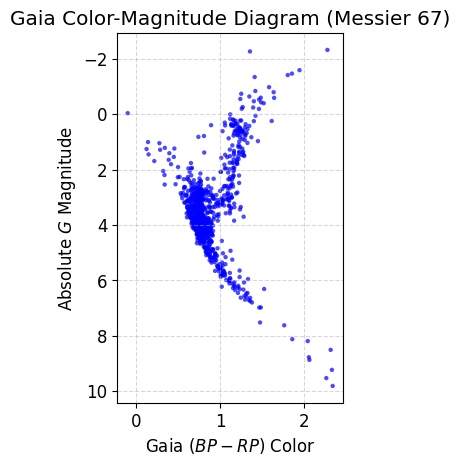

In [79]:
# Panel (a): Gaia CMD
plt.subplot(1, 2, 1)

# Calculate distances in parsecs
parallax = data_after_cuts['parallax'].values  # in milliarcseconds
distance_pc = 1000 / parallax

# Calculate Absolute G Magnitude
G_abs = data_after_cuts['phot_g_mean_mag'] - 5 * np.log10(distance_pc / 10)

# Gaia BP - RP color
BP_RP = data_after_cuts['bp_rp']

# Plotting
plt.scatter(BP_RP, G_abs, s=10, color='blue', alpha=0.7, edgecolors='none')

# Invert y-axis (brighter stars at the top)
plt.gca().invert_yaxis()

# Labels and Title
plt.xlabel(r'Gaia $(BP - RP)$ Color')
plt.ylabel(r'Absolute $G$ Magnitude')
plt.title('Gaia Color-Magnitude Diagram (Messier 67)')

# Grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)


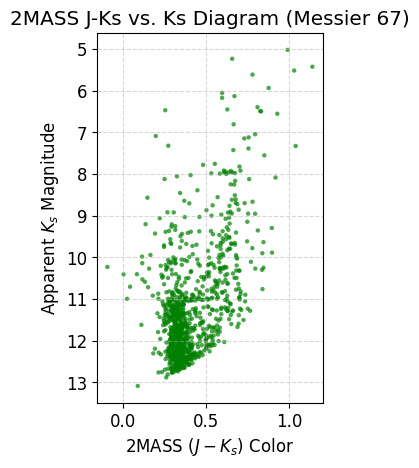

In [80]:
# Panel (b): 2MASS J-Ks vs. Apparent Ks Magnitude
plt.subplot(1, 2, 2)

# Extract J and Ks magnitudes
J_mag = data_after_cuts['j_m']
Ks_mag = data_after_cuts['ks_m']

# Calculate J - Ks Color
J_Ks = J_mag - Ks_mag

# Plotting
plt.scatter(J_Ks, Ks_mag, s=10, color='green', alpha=0.7, edgecolors='none')

# Invert y-axis (brighter stars at the top)
plt.gca().invert_yaxis()

# Labels and Title
plt.xlabel(r'2MASS $(J - K_s)$ Color')
plt.ylabel(r'Apparent $K_s$ Magnitude')
plt.title('2MASS J-Ks vs. Ks Diagram (Messier 67)')

# Grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)


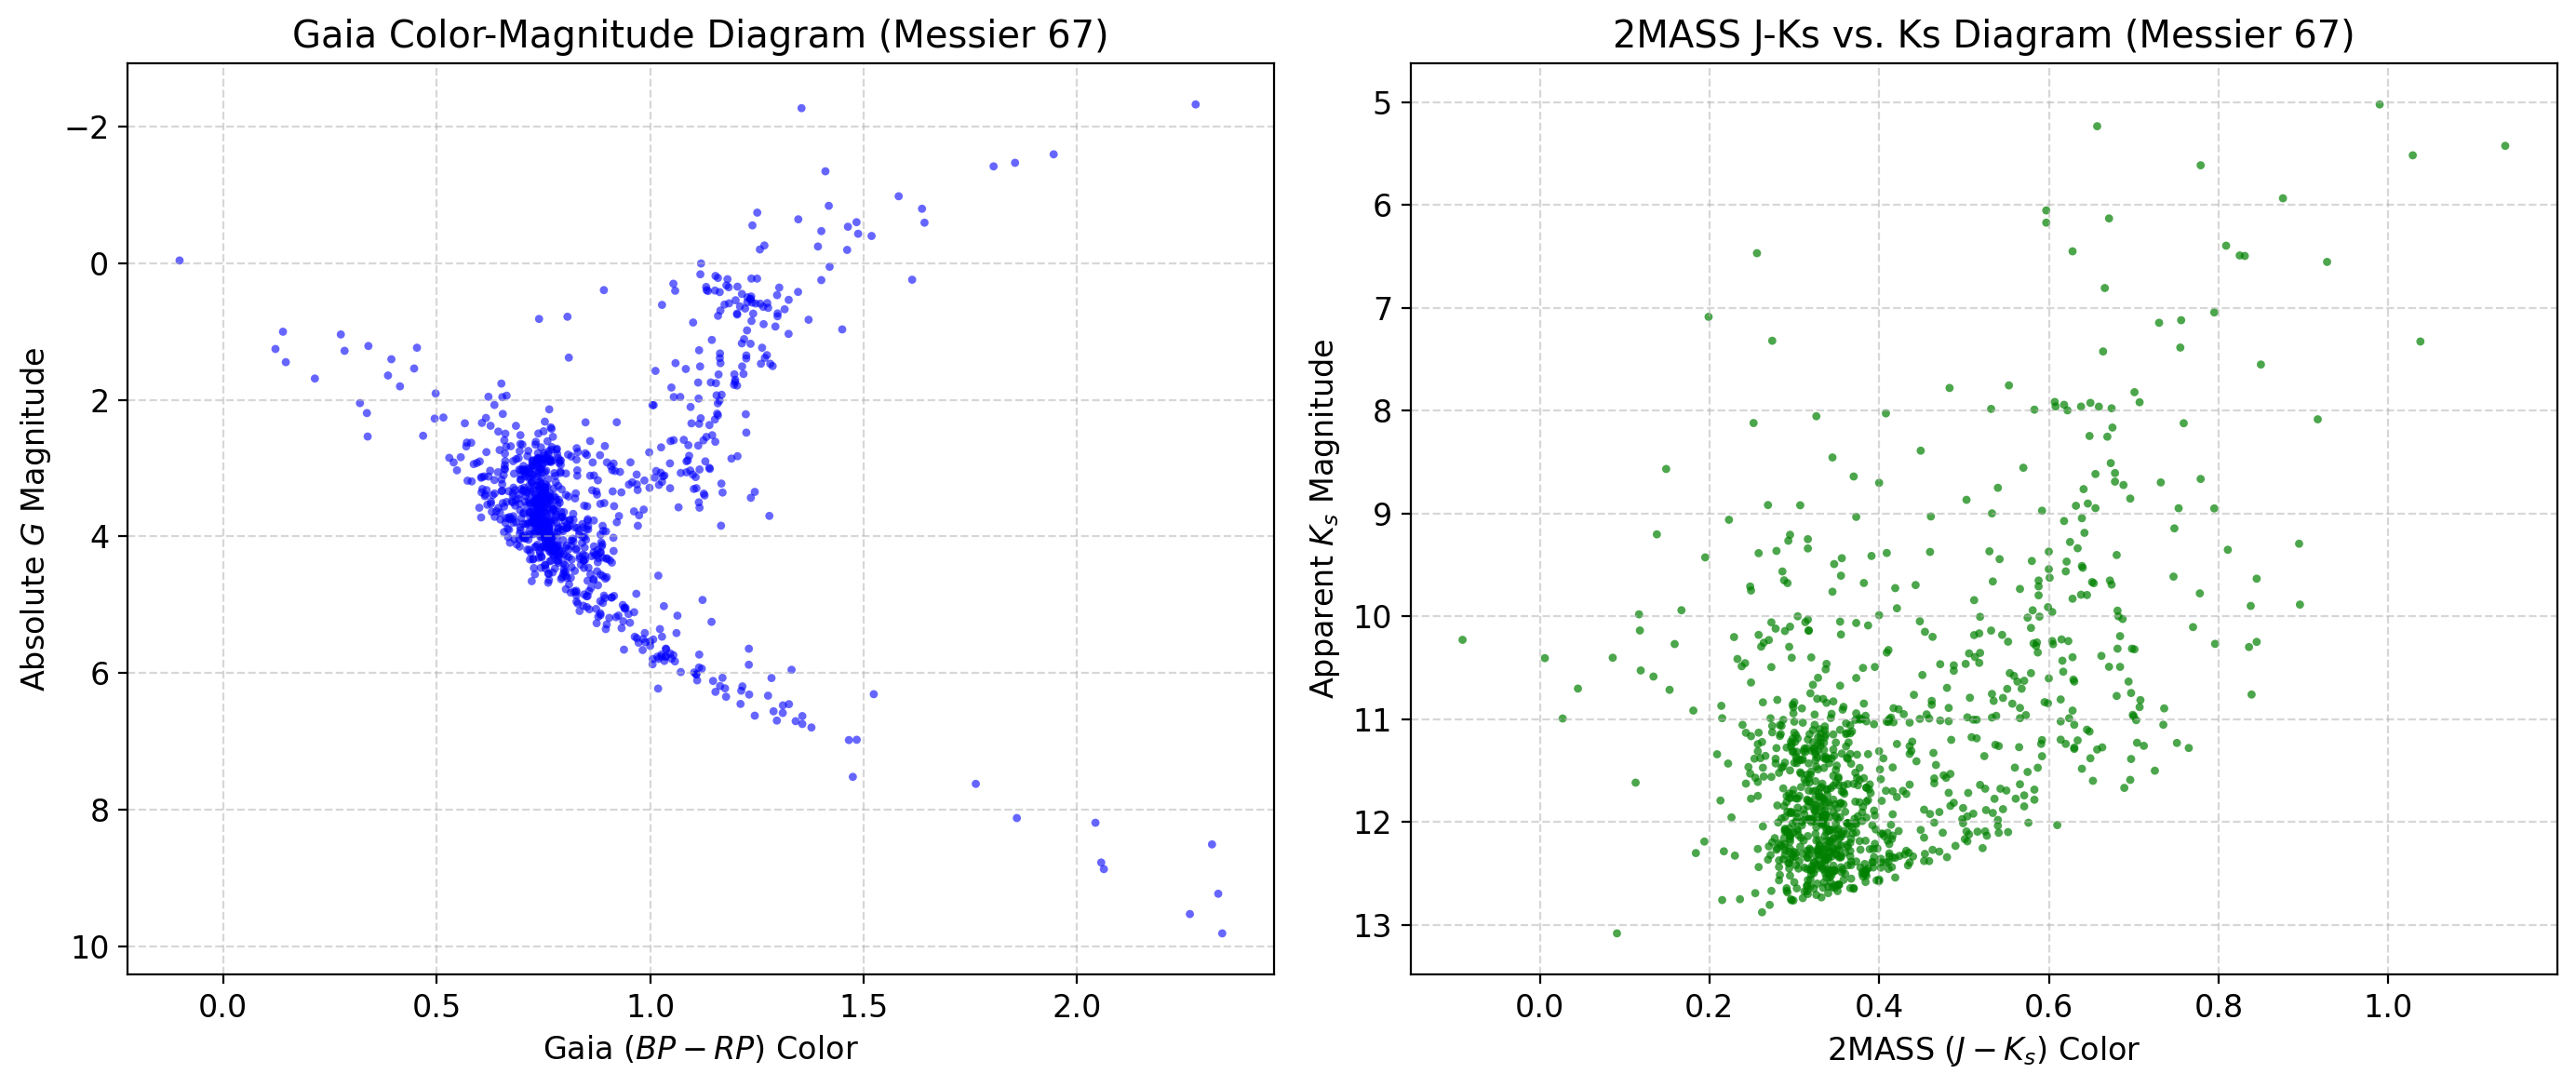

In [83]:
# Adjust layout for better spacing
# Step 5: Generate the Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=200)
plt.rcParams.update({'font.size': 12})

# Panel (a): Gaia CMD
ax1 = axes[0]
parallax = data_after_cuts['parallax'].values  # in milliarcseconds
distance_pc = 1000 / parallax
G_abs = data_after_cuts['phot_g_mean_mag'] - 5 * np.log10(distance_pc / 10)
BP_RP = data_after_cuts['bp_rp']

ax1.scatter(BP_RP, G_abs, s=10, color='blue', alpha=0.6, edgecolors='none')
ax1.invert_yaxis()
ax1.set_xlabel(r'Gaia $(BP - RP)$ Color')
ax1.set_ylabel(r'Absolute $G$ Magnitude')
ax1.set_title('Gaia Color-Magnitude Diagram (Messier 67)')
ax1.grid(True, linestyle='--', alpha=0.5)

# Panel (b): 2MASS J-Ks vs. Ks Diagram
ax2 = axes[1]
J_mag = data_after_cuts['j_m']
Ks_mag = data_after_cuts['ks_m']
J_Ks = J_mag - Ks_mag

ax2.scatter(J_Ks, Ks_mag, s=10, color='green', alpha=0.7, edgecolors='none')
ax2.invert_yaxis()
ax2.set_xlabel(r'2MASS $(J - K_s)$ Color')
ax2.set_ylabel(r'Apparent $K_s$ Magnitude')
ax2.set_title('2MASS J-Ks vs. Ks Diagram (Messier 67)')
ax2.grid(True, linestyle='--', alpha=0.5)

# Finalizing the Figure
plt.tight_layout()

# Create 'figures' directory if it doesn't exist
if not os.path.exists('figures'):
    os.makedirs('figures')

# Save the figure
plt.savefig('figures/cmds_M67.png', dpi=200)
plt.show()